In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from fastai.vision import *
from fastai.metrics import accuracy
import re
import scipy.ndimage
import fastai

from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform

In [3]:
PATH = "/scratch/as3ek/chrc_data_case_preserved_1000_normal/"
sz=512
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1.1)

In [4]:
data = (ImageItemList.from_folder(PATH)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=sz)
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [7]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    
    def forward(self, x): 
        return torch.cat([self.mp(x), self.ap(x)], 1)
    
    
custom_head = nn.Sequential(
                            AdaptiveConcatPool2d(),
                            Flatten(), 
                            nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.Dropout(p=0.25),
                            nn.Linear(in_features=4096, out_features=512, bias=True),
                            nn.ReLU(),
                            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.Dropout(p=0.5),
                            nn.Linear(in_features=512, out_features=10, bias=True),
                            nn.ReLU(),
                            nn.Linear(in_features=10, out_features=3, bias=True),
                            nn.LogSoftmax()
                           )

In [8]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, custom_head=custom_head)

In [10]:
learn.load('resnet_10_output_1_epoch');

#### Grad CAM

In [21]:
# we are going to use the output of the last Bottleneck as feature maps
# this is hardcoded for resnet50
target_layer = learn.model[0][7][2]
target_layer

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

In [22]:
# hook for the feature maps
fmap_hook = fastai.callbacks.hook_output(target_layer)

In [24]:
# hook for the gradients 
def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

gradient_hook = fastai.callbacks.Hook(target_layer, gradient_torch_hook, is_forward=False)

In [76]:
# we start by extracting a batch then choosing one image and label from that batch
# i is the index of the chosen image
i = 13
image_batch, label_batch = next(iter(learn.data.train_dl))
image = image_batch[i].reshape(1, 3, 512, 512)
label = label_batch[i].reshape(-1)

In [77]:
learn.model.eval();

In [78]:
# running the forward pass
learn.model.zero_grad();
out = learn.model(image)

# we need to set the gradients at the output to ones at the predicted class
# and zero everywere else
onehot = torch.zeros(learn.data.c)
onehot[torch.argmax(out)] = 1.0

# we then backprop from there
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

/home/as3ek/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [79]:
gradients = next(iter(gradient_hook.stored))
gradients.shape

torch.Size([1, 2048, 16, 16])

In [80]:
gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1)
fmaps = fmap_hook.stored.cpu().numpy()
print(fmaps.shape)
fmaps = fmaps.reshape(2048, 16, 16)

(1, 2048, 16, 16)


In [81]:
# relu on the heatmap
heatmap = np.maximum(0, np.einsum('i, ijk',gradient_linearization, fmaps))

# we now upsample the heatmap so we can overlay it on our original image
upsampled = scipy.ndimage.zoom(heatmap, 32)
upsampled = (upsampled - np.min(upsampled))/(np.max(upsampled) - np.min(upsampled))

In [82]:
def image_from_tensor(imagetensor):
    numpied = torch.squeeze(imagetensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied

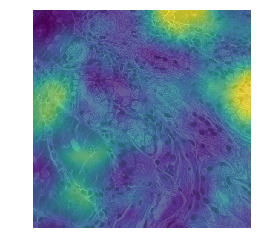

In [85]:
plt.imshow(image_from_tensor(image))
plt.imshow(upsampled, alpha=.8)
plt.gca().set_axis_off()

#### Guided Backprop

In [86]:
# we ask the model to compute the gradients wrt the image:
image.requires_grad_()

# and then perform our forward and backward passes, forcing the gradient to be 1 for our predicted class
out = learn.model(image)
out.backward(gradient=onehot.reshape(1, -1).cuda())

/home/as3ek/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


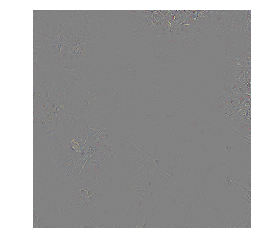

In [87]:
plt.imshow(image_from_tensor(image.grad))
plt.gca().set_axis_off()

In [88]:
## this callback will make all gradients positive during backprop
def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)

In [89]:
## we inventory all Relu Modules
relu_modules = [module[1] for module in learn.model.named_modules() if str(module[1]) == "ReLU(inplace)"]
len(relu_modules)

17

In [90]:
## and register our hooks with fastai
hooks = fastai.callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False)

In [91]:
learn.model.eval()
image.requires_grad_()
learn.model.zero_grad()
out = learn.model(image)

/home/as3ek/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [92]:
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

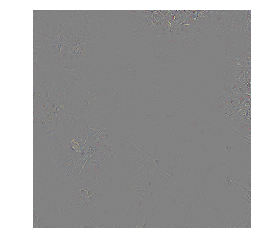

In [93]:
plt.imshow(image_from_tensor(image.grad))
plt.gca().set_axis_off()

In [95]:
gbp =  image_from_tensor(image.grad)

In [96]:
prod = np.einsum('ijk, ij->ijk',gbp, upsampled)

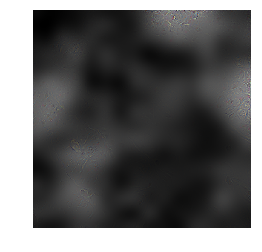

In [97]:
plt.imshow(prod)
plt.gca().set_axis_off()